In [107]:
import numpy as np
import pandas as pd
import scipy

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Methods implementation

### Linear regression model

In [108]:
def linear_prediction(w, X):
    """
    Returns a linear regression model prediction labels for objects in matrix 
    X using weights w:
    y_pred = (X,w)
    """
    if X.ndim == 1:
        return(np.insert(X, 0, 1).dot(w))
    else:
        n = X.shape[0]
        return np.dot(np.hstack((np.ones((n,1)),X)),w)

def mean_squared_error(y, y_pred):
    """
    Returns a mean squared error between real and predicted labels
    """
    y = np.array(y)
    y_pred = np.array(y_pred)
    mse = np.sum((y - y_pred)**2) / y.size
    return mse

def mean_absolute_error(y, y_pred):
    """
    Returns a mean absolute error between real and predicted labels
    """
    y = np.array(y)
    y_pred = np.array(y_pred)
    mae = np.sum(abs(y - y_pred)) / y.size
    return mae

def cost_function(w, X, y, type_f='mse'):
    """
    Returns a cost function of a linear model with coefficients w
    oh features X and labels y.
    """
    if (type_f == 'mae'):
        return mean_absolute_error(y, linear_prediction(w, X))
    elif (type_f == 'mse'):
        return mean_squared_error(y, linear_prediction(w, X))
    else:
        #raise
        print('error: incorrect type of function')
        return

def linear_regression_fit(X, y, minimize='grad_desc', cost_f='mse',
                          w0=None, eta=1e-2):
    """
    Returns weights that minimizes cost function.
    """   
    if (minimize == 'analytical'):
        # the cost function is 'mse' automatically
        # X_t = X.transpose()
        # w = np.linalg.inv(X_t.dot(X)).dot(X_t).dot(y)
        n = X.shape[0]
        X = np.hstack((np.ones((n,1)),X))
        w = np.linalg.lstsq(X,y)[0]
        
    elif (minimize == 'grad_desc'):
        # the cost function is 'mse' automatically
        if(w0 == None):
            w0 = np.zeros(X.shape[1] + 1)
        n = X.shape[0]
        X = np.hstack((np.ones((n,1)),X))
        w = gradient_descent(X, y, w0, eta)[0]
        w = w.reshape(w.shape[0])

    elif (minimize == 'st_grad_desc'):
        # the cost function is 'mse' automatically
        if(w0 == None):
            w0 = np.zeros(X.shape[1] + 1)
        n = X.shape[0]
        X = np.hstack((np.ones((n,1)),X))
        w = stochastic_gradient_descent(X, y, w0, eta)[0]
        w = w.reshape(w.shape[0])
    
    elif (minimize == 'scipy_minimize'):
        if(w0 == None):
            w0 = np.zeros(X.shape[1] + 1)
        w = scipy.optimize.minimize(lambda w: cost_function(w, X, y, cost_f), w0).x
    else:
        #raise
        print('error: incorrect minimization method')
        return
    return w

### Gradient descent

In [109]:
def gradient_step(X, y, w, eta=0.01):
    grad = 2 * X.T.dot(X.dot(w) - y) / X.shape[0] 
    w_next = w - eta * grad 
    return w_next

def gradient_descent(X, y, w0=None, eta=1e-2,
                     max_iter=1e4, min_weight_dist=1e-8):    
    X = np.array(X)
    y = np.array(y)
    if(w0 == None):
        w0 = np.zeros(X.shape[1])
        
    w = w0
    weight_dist = np.inf
    errors = []
    iter_num = 0
        
    while weight_dist > min_weight_dist and iter_num < max_iter: 
        w_next = gradient_step(X, y, w, eta)        
        errors.append(mean_squared_error(y, X.dot(w_next)))
        weight_dist = np.linalg.norm(w_next - w)      
        w = w_next
        iter_num += 1
    return w, errors

### Stochastic gradient descent

In [110]:
def stochastic_gradient_step(X, y, w, k, eta=0.01):
    grad = 2 * (X[k].dot(w) - y[k]) * X[k,:] / X.shape[0] 
    w_next = w - eta * grad   
    return w_next

def stochastic_gradient_descent(X, y, w0=None, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42):    
    X = np.array(X)
    y = np.array(y)
    if(w0 == None):
        w0 = np.zeros(X.shape[1])
        
    w = w0
    weight_dist = np.inf
    errors = []
    iter_num = 0
    #import random
    #k = np.array(range(X.shape[0]))
    #random.shuffle(k)
    np.random.seed(seed)
        
    while weight_dist > min_weight_dist and iter_num < max_iter:  
        #print('\nit.',iter_num)
        #print('w: ',w)
        random_ind = np.random.randint(X.shape[0])
        #print('k: ',random_ind)
        w_next = stochastic_gradient_step(X, y, w, random_ind, eta)     
        errors.append(mean_squared_error(y, X.dot(w_next)))
        weight_dist = np.linalg.norm(w_next - w)      
        #print('d: ',weight_dist)
        w = w_next
        iter_num += 1
    return w, errors

# Data

### Generate / Import dataset

In [111]:
def normalize(X, mean_std=True):
    if mean_std:
        means, stds = X.mean(axis=0), X.std(axis=0)
        X = (X - means) / stds
    else:
        minim, maxim = data.min(axis = 0), data.max(axis = 0)
        X = (X - minim) / (maxim - minim)
    return X

In [125]:
from sklearn import datasets 

sample_size = 200
data, target = datasets.make_regression(n_samples = sample_size,
                                        n_features = 1, 
                                        n_informative = 1, 
                                        n_targets = 1, noise = 5.,
                                        coef = False, random_state = 2)
#data = normalize(data)

In [124]:
#data = pd.read_csv('Data/weights_heights.csv', index_col='Index')
data_frame = pd.read_csv('Data/advertising.csv')

features = ['TV'] # , 'Radio','Newspaper']
labels = ['Sales']
data = np.array(data_frame[features].values, dtype=float)[:sample_size]
target = np.array(data_frame[labels].values, dtype=float)[:sample_size]
target = target.reshape(target.shape[0])

data = normalize(data)

### Split dataset into train & test samples

In [126]:
from sklearn import cross_validation as cross_val

train_data, test_data, \
train_labels, test_labels = cross_val.train_test_split(data, target,
                                                       test_size = 0.3)

In [127]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [[-1.06079904]
 [ 0.61014409]
 [ 0.54235257]
 [-0.51688389]
 [ 0.39652016]] 
...

train_labels: 
 [-41.46821271  26.54114684   5.25235503 -21.56734831  15.80407304] ...


# Run models and output

### Auxiliary functions

In [128]:
def print_result(coef, true, predict, cut = 5):
    print('w:\n',coef,'\n')
    print('true vs. prediction:\n',vstack((true,predict)).T[:cut],'\n...')

In [129]:
def plot_for_one_feature(train_data, train_labels, w, title):
    x = np.linspace(train_data.min(), train_data.max(), 2).reshape((2,1))
    plt.figure(figsize = (8,5))
    plt.plot(train_data, train_labels, 'o', markersize = 3)
    #print(x)
    #print(linear_prediction(w, x))
    plt.plot(x, linear_prediction(w,x), '-', linewidth = 4)
    plt.xlabel('feature')
    plt.ylabel('label')
    plt.title(title)
    plt.show()

### Analytical OLS method

w:
 [  0.37664723  37.96096985] 

true vs. prediction:
 [[  8.34655722  14.87265984]
 [-27.05864665 -13.45933257]
 [ 17.01843985  16.83258835]
 [ 19.7583686   15.03254436]
 [ 12.29620556  14.81973222]] 
...


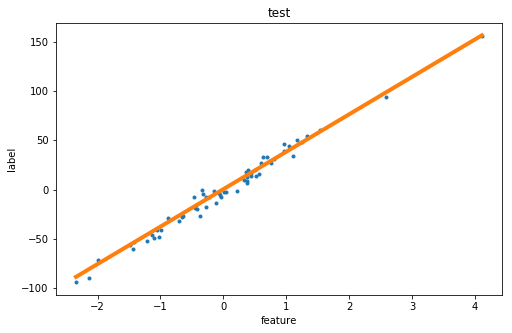

In [130]:
w = linear_regression_fit(train_data, train_labels, minimize='analytical')
print_result(w,test_labels,linear_prediction(w, test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')

### Numerical method using gradient descent

/Users/Yaroslava/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # Remove the CWD from sys.path while we load stuff.


w:
 [  0.37664726  37.96096984] 

true vs. prediction:
 [[  8.34655722  14.87265986]
 [-27.05864665 -13.45933254]
 [ 17.01843985  16.83258837]
 [ 19.7583686   15.03254438]
 [ 12.29620556  14.81973225]] 
...


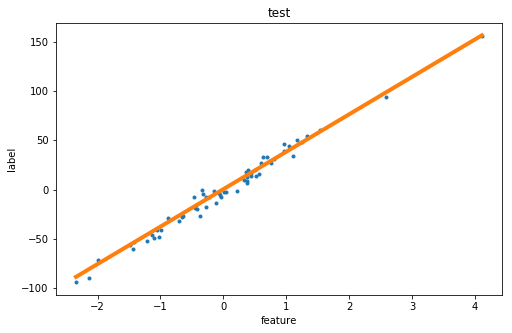

In [131]:
w0 = np.array([1,0])
w = linear_regression_fit(train_data, train_labels,
                          minimize='grad_desc', eta=0.1)

print_result(w,test_labels,linear_prediction(w, test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')

### Numerical method using stochastic gradient descent

/Users/Yaroslava/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # Remove the CWD from sys.path while we load stuff.


w:
 [  0.4501855   37.88957885] 

true vs. prediction:
 [[  8.34655722  14.91893628]
 [-27.05864665 -13.35977378]
 [ 17.01843985  16.87517888]
 [ 19.7583686   15.07852012]
 [ 12.29620556  14.86610821]] 
...


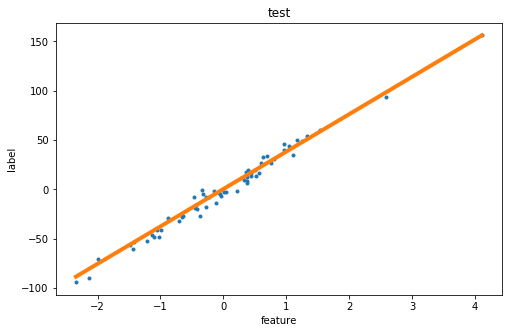

In [132]:
w0 = np.array([1,0])
w = linear_regression_fit(train_data, train_labels,
                          minimize='st_grad_desc', eta=0.05)

print_result(w,test_labels,linear_prediction(w, test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')

### Numerical method using scipy.optimize.minimize

w:
 [  0.35737411  38.38467379] 

true vs. prediction:
 [[  8.34655722  15.01518494]
 [-27.05864665 -13.63303692]
 [ 17.01843985  16.99698933]
 [ 19.7583686   15.17685403]
 [ 12.29620556  14.96166658]] 
...


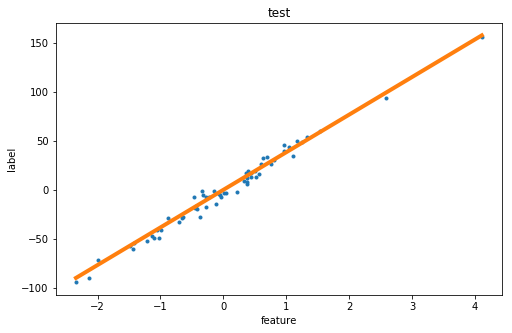

In [133]:
w0 = np.array([1,0])
w = linear_regression_fit(train_data, train_labels, minimize='scipy_minimize', cost_f='mae')

w.reshape((1,w.shape[0]))
print_result(w,test_labels,linear_prediction(w, test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')

### sklearn.linear_model.SGDRegression for check

w:
 [  0.37838901  37.87078676] 

true vs. prediction:
 [[  8.34655722  14.83996373]
 [-27.05864665 -13.42472094]
 [ 17.01843985  16.79523609]
 [ 19.7583686   14.99946842]
 [ 12.29620556  14.78716186]] 
...


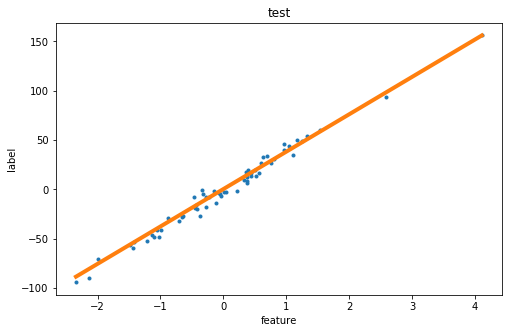

In [134]:
from sklearn import linear_model 

sgd_regressor = linear_model.SGDRegressor(random_state=None, n_iter=20)
sgd_regressor.fit(train_data, train_labels)
sgd_regressor.predict(test_data)
w = [sgd_regressor.intercept_[0]]
w.extend(sgd_regressor.coef_)
w = np.array(w)
print_result(w,test_labels,sgd_regressor.predict(test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')